In [3]:
import pandas as pd

df= pd.read_csv("/content/MachineLearningRating_v4.csv")
df.head()

<ipython-input-3-1301563624>:3: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv("/content/MachineLearningRating_v4.csv")


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,LossRatio,HadClaim
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0.0,0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0.0,0
2,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,0.0,0
3,145247,12827,2015-01-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,3.256435,0.0,0.0,0
4,145247,12827,2015-04-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,50.474737,0.0,0.0,0


**Data Preparation**

In [12]:
# Filter only policies that had claims > 0
df_claims = df[df['TotalClaims'] > 0].copy()

# Target variable
target = 'TotalClaims'

# Feature selection — you can refine this later
features = [
    'TotalPremium', 'CustomValueEstimate', 'Gender', 'Province',
    'VehicleType', 'RegistrationYear', 'PostalCode'
]

# Subset the dataframe
df_model = df_claims[features + [target]].dropna()

# Encode categorical features
df_model = pd.get_dummies(df_model, drop_first=True)

# Train/test split
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=[target])
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Train Models**

**Linear Regression (Baseline)**

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression — RMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}")


Linear Regression — RMSE: 44745.43, R²: 0.25


**Random Forest**

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest — RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")


Random Forest — RMSE: 49807.47, R²: 0.07


**XGBoost**

In [15]:
!pip install xgboost
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost — RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.2f}")


XGBoost — RMSE: 52834.74, R²: -0.04


**Model Comparison Table**

In [16]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb],
    'R²': [r2_lr, r2_rf, r2_xgb]
})

results.sort_values(by='RMSE')


,Model,RMSE,R²
0,Linear Regression,44745.433318,0.251810
1,Random Forest,49807.466832,0.072949
2,XGBoost,52834.738065,-0.043166


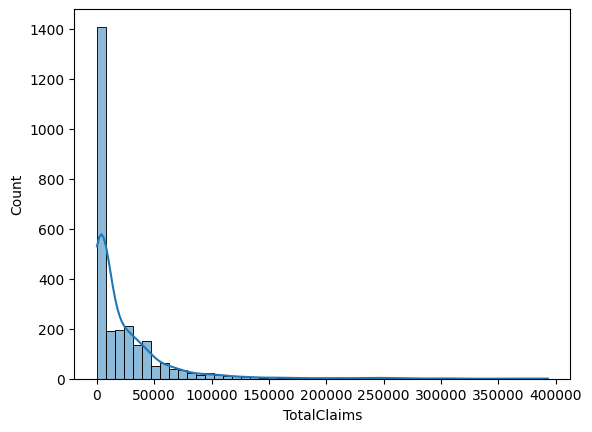

In [17]:
import seaborn as sns
sns.histplot(df_claims['TotalClaims'], bins=50, kde=True)
df_model['log_TotalClaims'] = np.log1p(df_model[target])
y = df_model['log_TotalClaims']


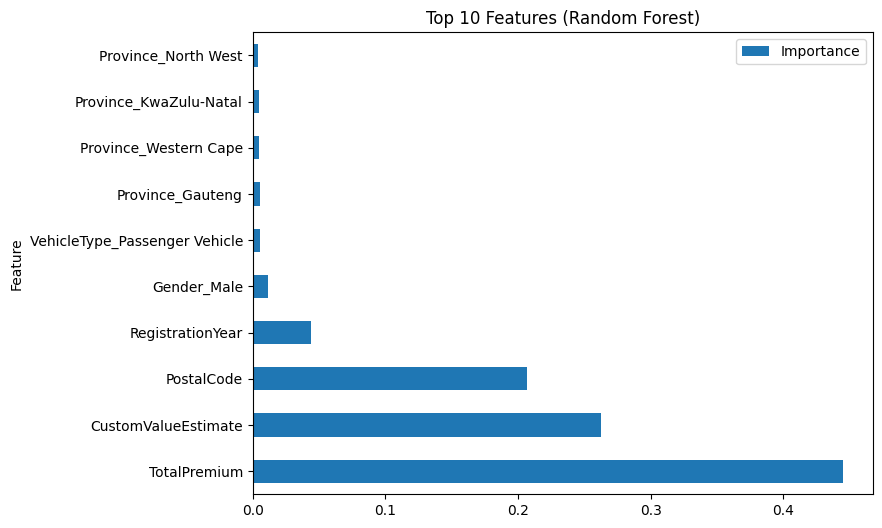

In [18]:
import matplotlib.pyplot as plt
importances = rf.feature_importances_
feat_names = X.columns

feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df.sort_values('Importance', ascending=False).head(10).plot(
    x='Feature', y='Importance', kind='barh', title='Top 10 Features (Random Forest)', figsize=(8,6)
)
plt.show()


In [19]:
# Step 1: Log-transform target
df_model['log_TotalClaims'] = np.log1p(df_model['TotalClaims'])

# Step 2: Split data
X = df_model.drop(columns=['TotalClaims', 'log_TotalClaims'])
y_log = df_model['log_TotalClaims']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train
rf_log = RandomForestRegressor(n_estimators=100, random_state=42)
rf_log.fit(X_train, y_train)

# Predict on log scale, convert back
y_pred_log = rf_log.predict(X_test)
y_pred_actual = np.expm1(y_pred_log)
y_true_actual = np.expm1(y_test)

# Evaluate on original scale
rmse_log = np.sqrt(mean_squared_error(y_true_actual, y_pred_actual))
r2_log = r2_score(y_true_actual, y_pred_actual)

print(f"Random Forest (log target) — RMSE: {rmse_log:.2f}, R²: {r2_log:.2f}")


Random Forest (log target) — RMSE: 47658.74, R²: 0.15


**SHAP Interpretation (on rf_log)**

In [29]:
!pip install shap
import shap
import matplotlib.pyplot as plt




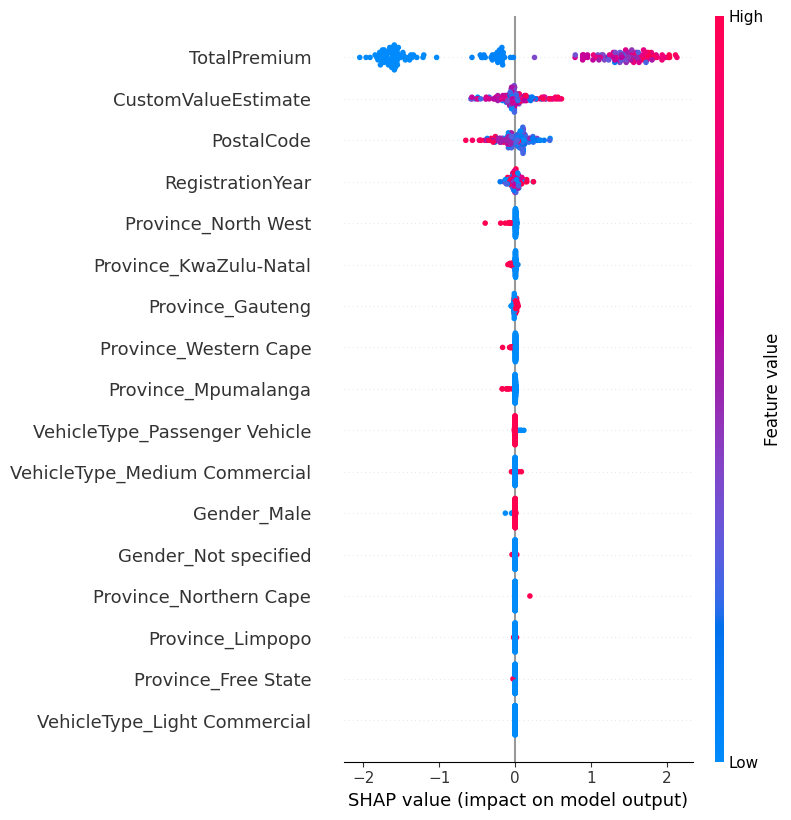

In [31]:

# Sample and copy
X_sample = X_train.sample(200, random_state=42).copy()

# Force all columns to float64
X_sample = X_sample.astype('float64')


# Drop any columns that still contain NaN due to conversion issues
X_sample = X_sample.dropna(axis=1)
explainer = shap.Explainer(rf_log, X_sample)
shap_values = explainer(X_sample)
shap.summary_plot(shap_values, X_sample)


**summary**

## 🔍 SHAP Interpretation — Model Explainability

We used SHAP (SHapley Additive exPlanations) to interpret the feature influence on claim severity predictions made by the Random Forest model.

### 📊 SHAP Summary Plot Insights:

- **TotalPremium** was the most influential feature — as expected, higher premiums correlate with higher predicted claims.
- **CustomValueEstimate** and **RegistrationYear** also had moderate influence. Newer vehicles or those with higher value may increase risk.
- **Certain PostalCodes and Provinces** appear in the top features, suggesting some regional variation in claim severity.
- Gender and VehicleType had minimal influence on the model, reinforcing findings from hypothesis testing.

### 🧠 Business Takeaway:

SHAP confirms that:
- A small number of features dominate model predictions.
- Geolocation and vehicle value have meaningful predictive power.
- The model could benefit from richer behavioral or driving history data for further improvement.
